## Quantum Fourier Transform

In [1]:
from qiskit.circuit.library import QFT

# create QFT circuit
qft_circuit = QFT(4)

In [2]:
from qiskit import QuantumCircuit

circuit = QuantumCircuit(4)

circuit.x(range(4))
circuit.barrier()
circuit.compose(qft_circuit, inplace=True)

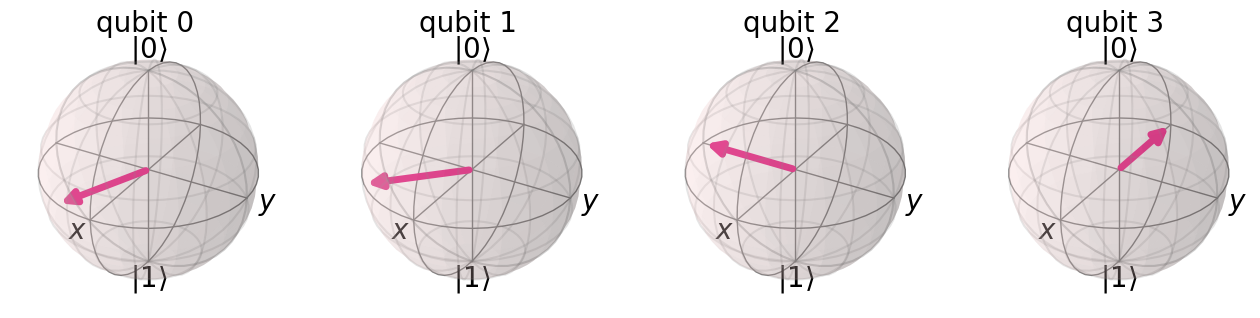

In [3]:
from qiskit.quantum_info import Statevector
from qiskit.visualization import plot_bloch_multivector

sv = Statevector(circuit)
plot_bloch_multivector(sv)

In [4]:
circuit.barrier()

# measurement in x basis
circuit_x = circuit.copy()
circuit_x.h(range(4))
circuit_x.measure_all()

# measurement in y basis
circuit_y = circuit.copy()
circuit_y.sdg(range(4))
circuit_y.h(range(4))
circuit_y.measure_all()

## Functions

In [5]:
def get_qubit_prob(counts):
  n_qubits = len(next(iter(counts)))  
  qubit_counts = [0] * n_qubits
  shots = sum(counts.values())

  for k, v in counts.items():
    for i, x in enumerate(k):
      if x == '1':
        qubit_counts[i] += v
  
  return [c / shots for c in reversed(qubit_counts)]

In [6]:
def get_phase(x_prob, y_prob):
  from math import atan2
  phase = []
  for px, py in zip(x_prob, y_prob):
    cos_phi = 1 - 2 * px
    sin_phi = 1 - 2 * py
    phi = atan2(sin_phi, cos_phi)
    phase.append(phi)
  return phase

In [7]:
def get_statevector_from_phase(phase):
  temp_circuit = QuantumCircuit(len(phase))
  temp_circuit.h(range(len(phase)))
  for i, p in enumerate(phase):
    temp_circuit.p(p, i)
  return Statevector(temp_circuit)

## Simulator

In [8]:
from qiskit_ionq import IonQProvider
provider = IonQProvider("your_private_token")

In [9]:
from qiskit import transpile

simulator_backend = provider.get_backend("ionq_simulator")
sim_circuit_x = transpile(circuit_x, simulator_backend)
sim_circuit_y = transpile(circuit_y, simulator_backend)

In [10]:
job_x = simulator_backend.run(sim_circuit_x, shots=10000)
job_y = simulator_backend.run(sim_circuit_y, shots=10000)

In [11]:
x_prob = get_qubit_prob(job_x.get_counts())
y_prob = get_qubit_prob(job_y.get_counts())

In [12]:
phase = get_phase(x_prob, y_prob)
phase

[-0.3764557099063939,
 -0.7690523814528886,
 -1.5605966805088167,
 3.1339927999100556]

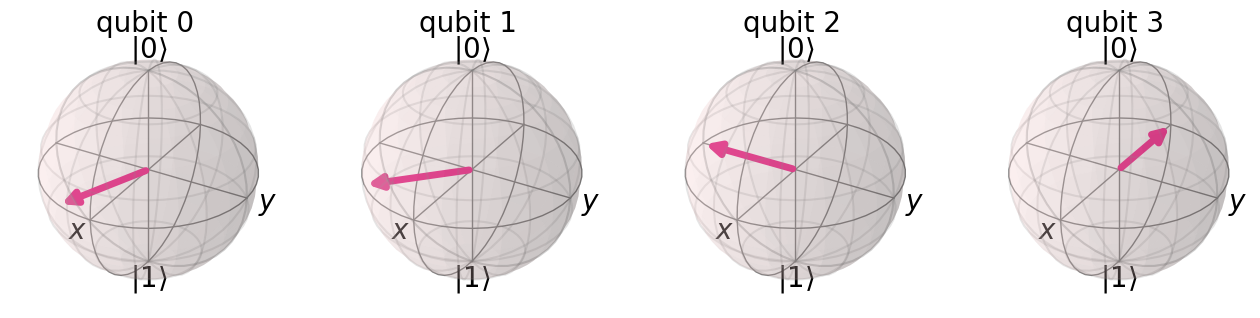

In [13]:
sv = get_statevector_from_phase(phase)
plot_bloch_multivector(sv)

## QPU

In [14]:
qpu_backend = provider.get_backend("ionq_qpu")
qpu_circuit_x = transpile(circuit_x, qpu_backend)
qpu_circuit_y = transpile(circuit_y, qpu_backend)

In [15]:
qpu_job_x = qpu_backend.run(qpu_circuit_x, shots=10000)
qpu_job_y = qpu_backend.run(qpu_circuit_y, shots=10000)

In [16]:
from qiskit.providers.jobstatus import JobStatus
import time

while ((qpu_job_x.status() is not JobStatus.DONE) or 
       (qpu_job_y.status() is not JobStatus.DONE)):
	print(f'qpu_job_x: {qpu_job_x.status()}, qpu_job_y: {qpu_job_y.status()}')
	time.sleep(60)
print(f'qpu_job_x: {qpu_job_x.status()}, qpu_job_y: {qpu_job_y.status()}')

qpu_job_x: JobStatus.QUEUED, qpu_job_y: JobStatus.QUEUED
qpu_job_x: JobStatus.QUEUED, qpu_job_y: JobStatus.QUEUED
qpu_job_x: JobStatus.QUEUED, qpu_job_y: JobStatus.QUEUED
qpu_job_x: JobStatus.QUEUED, qpu_job_y: JobStatus.QUEUED
qpu_job_x: JobStatus.DONE, qpu_job_y: JobStatus.QUEUED
qpu_job_x: JobStatus.DONE, qpu_job_y: JobStatus.QUEUED
qpu_job_x: JobStatus.DONE, qpu_job_y: JobStatus.QUEUED
qpu_job_x: JobStatus.DONE, qpu_job_y: JobStatus.DONE


In [17]:
qpu_x_prob = get_qubit_prob(qpu_job_x.get_counts())
qpu_y_prob = get_qubit_prob(qpu_job_y.get_counts())

In [18]:
qpu_phase = get_phase(qpu_x_prob, qpu_y_prob)
qpu_phase

[-0.29865111873171285,
 -1.443242297452567,
 -2.051483867828738,
 2.944315366950479]

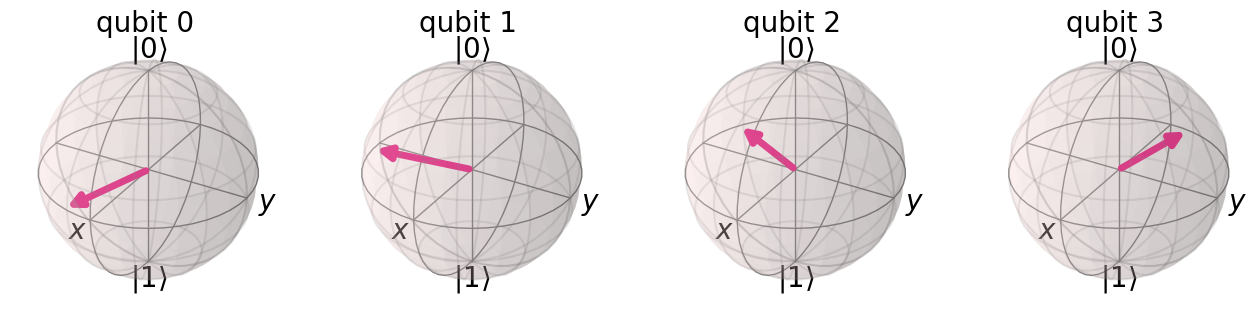

In [19]:
qpu_sv = get_statevector_from_phase(qpu_phase)
plot_bloch_multivector(qpu_sv)